# 1. Raw Data Visualization and Preprocessing

In [5]:
# load data from local source
import numpy as np
Fraw = np.load('./example_mice/JUV015/220408/F.npy')
ops = np.load('./example_mice/JUV015/220408/ops.npy',allow_pickle=True)
neuropil = np.load('./example_mice/JUV015/220408/Fneu.npy')
cells = np.load('./example_mice/JUV015/220408/iscell.npy')
stat = np.load('./example_mice/JUV015/220408/stat.npy',allow_pickle=True)

/Users/madeline/Documents/Ca2


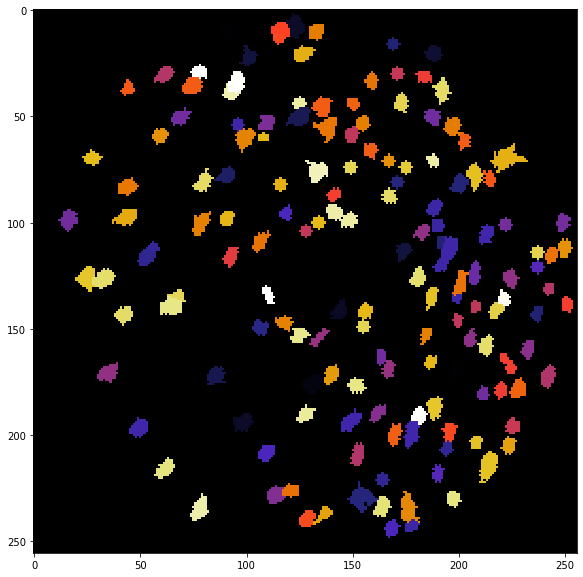

In [2]:
# plot ROIs

from matplotlib import pyplot as plt 
import random
im = np.zeros((256,256))
for cell in range(0,cells.shape[0]):
    if cells[cell,0] > 0:
        xs = stat[cell]['xpix']
        ys = stat[cell]['ypix']
        im[ys, xs] = random.random()
fig = plt.figure(figsize=(10,10))
pos = plt.imshow(im, cmap='CMRmap')

In [6]:
# preprocessing

F = Fraw - neuropil*0.7 # subtract neuropil

# find number of cells
numcells = 0
for cell in range(0,len(cells)):
    if cells[cell,0] == 1.0: # if ROI is a cell
        numcells += 1

Fcells = np.zeros((numcells,F.shape[1])) # create new F matrix with only data from ROIs that are cells
counter = 0
for cell in range(0,len(cells)):
    if cells[cell,0] == 1.0: # if ROI is a cell
        Fcells[counter] = F[cell]
        counter += 1

In [7]:
# Alternative possible calculations of F0

#F = Fraw - neuropil*0.7 # subtract neuropil   

#F0 = [] # method 1 for F0
#for roi in range(0,F.shape[0]):
#    include_frames = []
#    std = np.std(F[roi])
#    avg = np.mean(F[roi])
#    for frame in range(0,F.shape[1]):
#        if F[roi, frame] < std+avg:
#            include_frames.append(F[roi,frame])
#    F0.append(np.mean(include_frames))
    
#F0_med = np.median(F,1)
#F0_8pc = np.percentile(F,8,1)

#x = 500
#F0_mov = np.zeros(F.shape)
#for roi in range(0,F.shape[0]):
#    for frame in range(0,F.shape[1]):
#        if frame == 0:
#            avg = F[roi, 0]
#        elif frame < x:
#            avg = np.mean(F[roi, 0:frame])
#        elif frame > F.shape[1] - x:
#            avg = np.mean(F[roi, frame:])
#        elif F.shape[1] - x > frame > x:
#            avg = np.mean(F[roi, frame-x:frame+x])
#        F0_mov[roi, frame] = avg

In [8]:
# F0 and dF/F calculations

%cd U19_CADA_analysis/ # F0 from Albert
from utils import robust_filter
F0_AQ = np.zeros(Fcells.shape)
for cell in range(Fcells.shape[0]):
    F0_AQ[cell] = robust_filter(Fcells[cell], method=12, window=200, optimize_window=2, buffer=False)[:, 0]
%cd ..

dFF = np.zeros(Fcells.shape) # d
for cell in range(0,Fcells.shape[0]):
    for frame in range(0,Fcells.shape[1]):
        dFF[cell, frame] = (Fcells[cell, frame] - F0_AQ[cell, frame]) / F0_AQ[cell, frame]

/Users/madeline
[Errno 2] No such file or directory: 'U19_CADA_analysis/ # F0 from Albert'
/Users/madeline
/Users


In [ ]:
# plot ROI next to its fluorescence trace!

counter = -1
for cell in range(0,cells.shape[0]):
    if cells[cell,0] > 0:
        counter += 1
        im = np.zeros((212,212))
        xs = stat[cell]['xpix']
        ys = stat[cell]['ypix']
        im[ys, xs] = random.random()
        plt.figure(figsize=(16,4))
        #fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3]})
        plt.subplot(1, 2, 1)
        plt.imshow(im, cmap='CMRmap')
        plt.subplot(1, 2, 2)
        plt.plot(dFF[counter,15000:20000], label = "ROI no." + str(cell) + "; Cell no." + str(counter))
        plt.legend()

# 2. Establishing Baseline Activity
For use in determining significance of fluorescent response to cues. Written by Albert!

In [19]:
# load behavior info
import pandas as pd
behav = pd.read_csv(r'./example_mice/JUV015/220408/JUV015_220408_behavior_output.csv')
import h5py
with h5py.File(r'./example_mice/JUV015/220408/JUV015_220408_behaviorLOG.mat', 'r') as hf:
    frame_time = np.array(hf['out/frame_time']).ravel()

In [20]:
# calculate baseline level of activity

from statsmodels.tsa.tsatools import lagmat
from scipy.interpolate import interp1d

def get_baseline_activities(y, X, future, past, fr=None):
    """ Select regions where covariate X has no effect on y after lagging.
    y: recording time series (neural data)
    X: 2D matrix, various covariations
    future/past = pre/post: Lag X backward by `pre` frames and forward by `post` frames, if fr 
    is unspecified, otherwise pre/post specifies the lag in seconds.
    pre = length of future effects, post = length of past effects 
    NOTE: **drops 'edges' automatically, see 'valid' mode in np.convolve**
    """
    # uniform lag everywhere
    pre, post = future, past
    if len(X.shape) == 1:
        X = X[:, np.newaxis]
    assert len(X.shape) == 2, 'reshape covariate to 2D'
    if fr is not None:
        pre, post = int(pre * fr), int(post * fr)
    y_t = y[pre:len(y)-post]
    X_lag = lagmat(X, pre+post, trim="none", original='in')
    X_lag = X_lag[post+pre:len(X_lag)-(pre+post)]
    return y_t[np.sum(np.abs(X_lag), axis=1) == 0]

def samples_to_discrete_timeseries(ts, xs=None, method='integration', fr=20, tmax=None):
    """ Turns potentially unevenly sampled timeseries into evenly sampled time series

    method: str
        integration: discretize through integration
        interp: resample data via interpolation
        state: resample data via interpolation approach using `traces` package
    """
    if xs is None:
        assert (method == 'integration'), 'must use integration method for binary timeseries'
        xs = np.full_like(ts, 1)
    if tmax is None:
        tmax = np.max(ts)
    dt = 1 / fr
    nT = np.floor(tmax / dt) + 1
    T = nT * dt
    ts_new = np.arange(0, T+dt, dt)
    if method == 'integration':
        ys, _ = np.histogram(ts, np.concatenate([ts_new, [ts_new[-1]+dt]]))
    elif method == 'interp':
        ys = interp1d(ts, xs, fill_value='extrapolate')(ts_new)
    elif method == 'state':
        assert 'traces' in globals(), 'traces must be installed'
    else:
        raise NotImplementedError(f'unknown method {method}')
    return ts_new, ys

In [21]:
beh_cols = ['outcome', 'first_lick_in', 'onset'] # select behavioral events
behavior_times = behav[beh_cols].values.T # processes structure of csv to create time stamps
tmax = max(60 * 60, np.nanmax(behavior_times)) 
X = []
for i in range(len(behavior_times)): # discretizes time stamps
    btimes = behavior_times[i]
    ti, xi = samples_to_discrete_timeseries(btimes[~np.isnan(btimes)], xs=None, method='integration', fr=8.052, tmax=tmax)
    X.append(xi)
X = np.array(X).T

In [22]:
# calculate baseline for all cells
i = 0
baselines = [None] * len(dFF)
for i in range(len(dFF)):
    tj,y = samples_to_discrete_timeseries(frame_time, dFF[i], method='interp', fr=8.052, tmax=tmax)
    baselines[i] = y
baselines = np.vstack(baselines).T
safe_region = tj >= frame_time.min()
baselines = get_baseline_activities(baselines[safe_region], X[safe_region, :], 2, 2, fr=8.052).T


In [27]:
## optional plot of baseline
#import scipy.stats
#from scipy.stats import bootstrap
#i = 0
#plt.plot(frame_time, dFF[i])
#xmean = np.mean(baselines[i])
#bounds = np.std(baselines[i]) / np.sqrt(len(baselines[i]))
#tlow, thigh = xmean - bounds, xmean+bounds
## res = bootstrap(baseline, np.mean, confidence_level=0.9)
## tlow, thigh = res.confidence_interval
#plt.fill_between(tj, tlow, thigh, alpha=0.3, color='r')
#plt.axhline(xmean, ls='-', color='r')

# 3. Aligning Ca2+ Imaging Data to Behavior
Note: this is adapted from Nick's pipeline_behavioral_albert notebook. It requires a modified version of behavioral_albert.py to run correctly! Modify lines 149-161 with the F0 and dFF calculations from above.

In [23]:
%cd madeline_analysis/
from behavioral_albert_MKedit import *
logging.getLogger().setLevel(logging.WARNING)
%matplotlib inline


/Users/madeline/Documents/Ca2/madeline_analysis


In [24]:
gse.encode_to_filename(animal, session, ['log']) # error: gse is not defined

NameError: name 'gse' is not defined

In [25]:
data_root = r'/Volumes/Wilbrecht_file_server/Madeline/processed_data'
gse = GoNoGo_Expr(data_root)
animal, session = 'JUV015', '220408'
bmat, gn_series = gse.load_animal_session(animal, session)
bdf, dff_df = bmat.todf(), gn_series.calculate_dff()

Changing plot_path as /Volumes/Wilbrecht_file_server/Madeline/plots


PermissionError: [Errno 13] Permission denied: '/Volumes/Wilbrecht_file_server'

In [ ]:
dff_df

In [ ]:
def plot_event(event, neuron_range, sound_range=list(range(1,17)), hue=None, x_axis=None, y_axis=None, palette=None):
    neurons = [f'neuron{i}' for i in range(*neuron_range)]
    neur_dff_df = dff_df[dff_df['roi'].isin(neurons)].reset_index(drop=True)
    nb_df = gse.nbm.align_B2N_dff_ID(bdf, neur_dff_df, [event], form='wide')
    plot_df = gse.nbm.lag_wide_df(nb_df, {f'{event}_neur': {'long':True}})
    plot_df = plot_df[plot_df['sound_num'].isin(sound_range)]
    if x_axis is None:
        x_axis = f'{event}_neur_time'
    if y_axis is None:
        y_axis = f'{event}_neur_ZdFF'
    if palette is None:
        palette = 'Spectral'
    p = sns.relplot(data=plot_df, x=f'{event}_neur_time', y=f'{event}_neur_ZdFF', hue=hue, row='roi', kind='line', palette=palette)
    p.set_xlabels(x_axis, fontsize = 15)
    p.set_ylabels(y_axis, fontsize = 15)
    
    # add in col='sound_num' to p = to plot by tone

In [ ]:
plot_event('onset',(89,155),
           sound_range=[1,2,3,4,5,6,7,8],
           hue='sound_num',
           x_axis="Aligned to Cue Onset",
           y_axis="dF/F",
           palette='seismic')

# 4. Test Significance of Fluorescent Responses to Behavioral Events

Here I need to write code to compare the fluorescent response in the two(?) seconds following an event to the baseline level of activity calculated above. Steps:
1. Align Ca2+ data of one neuron to behavioral event (this is done above)
2. Calculate estimated baseline activity for that neuron (done above)
3. Conduct a permutation test between the set of baseline activity values and all fluorescence values in our response window (~2s). Alternatively, use another statistical test to compare the average baseline activity value to the average fluorescence value in the response window.

# 5. Decoder Implementation
Adapted from Albert

In [ ]:
from pandas.core.resample import TimeGrouper
from sklearn.model_selection import KFold

class RR_Decoding(NBExperiment):
    RAND = 230

    def __init__(self, folder, animals):
        self.folder = folder
        if isinstance(animals, pd.DataFrame):
            self.nb_df = animals
        else:
            self.nb_df = pd.concat([self.load_nb_df_animal(folder, anim) for anim in animals]) # CHANGE "load_nb_df_animal" to ...?
        self.nbm = RRNBMat_DC(self.nb_df)
        self.col_kws = None

    def load_nb_df_animal(self, folder, animal): # not sure how much of this I need?
        animal_path = os.path.join(folder, animal)
        behavior_cols = ['animal', 'session', 'trial', ] # ADD APPROPRIATE BEHAVIORAL EVENTS
        lh_neur_f = os.path.join(animal_path, f'{animal}_NeuralWindow_LH.csv') # looks like this incorporates Ca2+ data but I don't have a csv for mine
        behavior = pd.read_csv(os.path.join(animal_path, f'{animal}_behavior_events.csv'),
                            skiprows=1, names=behavior_cols) # I think the csv I need was loaded above
                    # my behavior csv is JUV015_220408_behavior_output.csv
        lh_neur = pd.read_csv(lh_neur_f)
        lh_neur.rename(columns={col: f'LH--{col}' for col in lh_neur.columns[3:]}, inplace=True)
        nb_df = behavior.merge(lh_neur, 'left', left_on=['animal', 'session', 'trial'], 
                    right_on=['Animal', 'Session', 'Trial'])
        nb_df = nb_df.merge(rh_neur, 'left', left_on=['animal', 'session', 'trial'], 
                            right_on=['Animal', 'Session', 'Trial'])
        return nb_df
     
# NOT SURE HOW MUCH OF BELOW IS NEEDED!
    def divide_to_train_test(self, nb_df, method='80:20'):
        if method == '80:20':
            test_size = int(nb_df.shape[0] * 0.2)
            train_size = nb_df.shape[0] - test_size
            nbdf_inds = np.arange(nb_df.shape[0])
            np.random.seed(self.RAND)
            np.random.shuffle(nbdf_inds)
            nb_df_test = nb_df.iloc[nbdf_inds[:test_size], :].reset_index(drop=True)
            nb_df_train = nb_df.iloc[nbdf_inds[test_size:], :].reset_index(drop=True)
        elif method.startswith('session'):
            n_session = int(method.split('-')[1])
            id_df = nb_df[['animal']] + '|' + nb_df[['session']]
            nb_df['id'] = id_df
            uniq_ids = np.unique(id_df)
            np.random.seed(self.RAND)
            np.random.shuffle(nbdf_inds)
            test_ids = uniq_ids[:n_session]
            train_ids = uniq_ids[n_session:]
            nb_df_train = pd.concat([nb_df.loc[nb_df['id'] == itrain].reset_index(drop=True) for itrain in train_inds], axis=0)
            nb_df_test = pd.concat([nb_df.loc[nb_df['id'] == itest].reset_index(drop=True) for itest in test_inds], axis=0)
            nb_df_train.drop(columns='id')
            nb_df_test.drop(columns='id')
        return nb_df_train, nb_df_test 
    
    def get_decoding_label(self, nb_df, endog):
        # Returns the endogenous variable, or in other words: the y response vector
        return nb_df[endog]
    
    def set_col_keywords(self, col_kws):
        self.col_kws = col_kws
    
    def get_design_matrix(self, nb_df, dropna=True):
        # use Preprocessor if needed
        # col_kws: list of keywords use to filter column names
        nbdf_nc = self.nbm.get_aligned_neural_columns(nb_df).reset_index(drop=True)
        col_kws = self.col_kws
        if col_kws is not None:
            selected_cols = []
            for ckw in col_kws:
                selected_cols.append([col for col in nbdf_nc.columns if ckw in col])
            selected_cols = list(np.concatenate(selected_cols))
            nbdf_nc = nbdf_nc[selected_cols]
        if dropna:
            nonan_sel = np.all(~nbdf_nc.isnull(), axis=1)
            return nbdf_nc, nonan_sel
        return nbdf_nc

In [ ]:
# NOT SURE OF EXACT PARTS THAT NEED TO BE EDITED
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score
from sklearn.inspection import permutation_importance
event_windows = {'exit_neur{t-1}': [0, 1], 'tone_onset_neur': [-0.2, 0.3], 'T_Entry_neur': [-1, 1]}
rr_decode = RR_Decoding(data_root, nb_df_merged[nb_df_merged['animal'] == 'RRM031'].reset_index(drop=True))
rr_decode.set_col_keywords(['LH--'])
nb_df_train, nb_df_test = rr_decode.divide_to_train_test(rr_decode.nb_df)
X_model, nonan_sel = rr_decode.get_design_matrix(nb_df_train)
y_model = rr_decode.get_decoding_label(nb_df_train, 'accept')
X_model = filter_columns(X_model, event_windows)
rfclf = RandomForestClassifier(n_estimators=1000, random_state=rr_decode.RAND).fit(X_model[nonan_sel].values, y_model[nonan_sel].values)

X_test, nonan_test = rr_decode.get_design_matrix(nb_df_test)
y_test = rr_decode.get_decoding_label(nb_df_test, 'accept')[nonan_test]
y_hat = rfclf.predict(filter_columns(X_test, event_windows)[nonan_test].values)
# y_hat = rfclf.predict(rr_decode.get_design_matrix(nb_df_test).values)
print(balanced_accuracy_score(y_test, y_hat), roc_auc_score(y_test, y_hat), 
      f1_score(y_test, y_hat), accuracy_score(y_test, y_hat))